In [1]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pycatch22 as catch22
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer, LabelEncoder
from metric_learn import MMC_Supervised
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from collections import defaultdict
import palettable
import seaborn as sns
import matplotlib as mpl
import pickle
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from pysindy.feature_library import CustomLibrary, GeneralizedLibrary, TensoredLibrary
from sklearn.metrics import log_loss
import sdeint
from sklearn.metrics import roc_curve, auc
import sympy as smp
from sympy import real_roots

## Low Noise Space, Long N

In [2]:
def gen_limitCycle(num_samples, N_fixed=None, eta_fixed=None): 

    if N_fixed is None:
        N_val_hopf  = np.random.randint(50, 5000, size=num_samples)
    else:
        N_val_hopf = np.full(num_samples, N_fixed)
        
    if eta_fixed is None:
        eta_val_hopf = np.random.uniform(0.01, 1, size=num_samples)
    else:
        eta_val_hopf = np.full(num_samples, eta_fixed)
        
    mu_val_hopf = np.random.uniform(0.01, 5, size=num_samples)
    sols_list = list()
    lengths = list()
    dt = 0.01
    for i in range(num_samples):
        N_val = N_val_hopf[i]
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:, 0]) # only return x time series
        lengths.append(len(sol[500:, 0]))
    features_hopf = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features_hopf)
    df['N'] = lengths
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['model'] = 'Hopf'
    df['regime'] = 'Limit Cycle'
    return sols_list, df 


In [3]:
ts_lc_low_sig_high_N, df_lc_low_sig_high_N = gen_limitCycle(1000,N_fixed=2000, eta_fixed=0.3)

In [4]:
def gen_fixedpoint(num_samples, N_fixed=None, eta_fixed=None):
    num_samples = num_samples // 3
    #system 1 - hookes

    mu_val_hookes = np.random.uniform(-5, -0.01, size=num_samples)
    if N_fixed is None:
        N_val_hookes  = np.random.randint(50, 5000, size=num_samples)
        N_val_hopf  = np.random.randint(50, 5000, size=num_samples)
    else:
        N_val_hookes = np.full(num_samples, N_fixed)
        N_val_hopf = np.full(num_samples, N_fixed)
        
    if eta_fixed is None:
        eta_val_hookes = np.random.uniform(0.01, 1, size=num_samples)
        eta_val_hopf = np.random.uniform(0.01, 1, size=num_samples)
    else:
        eta_val_hookes = np.full(num_samples, eta_fixed)
        eta_val_hopf = np.full(num_samples, eta_fixed)

    sols_list_hookes = list()
    lengths = list()
    dt = 0.01
    for i in range(num_samples):
        N_val = N_val_hookes[i]
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list_hookes.append(sol[500:, 0])
        lengths.append(len(sol[500:, 0]))
    features_hookes = np.array([catch22.catch22_all(sols_list_hookes[i])['values'] for i in range(len(sols_list_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['N'] = lengths
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['model'] = 'Hookes'
    df_hookes['regime'] = 'Fixed Point'

    # system 2 - hopf 
   
    mu_val_hopf = np.random.uniform(-5, -0.01, size=num_samples) # sample 
    sols_list_hopf = list()
    lengths = list()
    dt = 0.01
    for i in range(num_samples):
        N_val = N_val_hopf[i]
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list_hopf.append(sol[500:, 0]) # only return x time series
        lengths.append(len(sol[500:, 0]))
    features_hopf = np.array([catch22.catch22_all(sols_list_hopf[i])['values'] for i in range(len(sols_list_hopf))])
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['N'] = lengths
    df_hopf['mu'] = mu_val_hopf
    df_hopf['eta'] = eta_val_hopf
    df_hopf['model'] = 'Hopf'
    df_hopf['regime'] = 'Fixed Point'

    # system 3 - bistable

    eta_val_bistable = list()
    mu_val_bistable = list()
    N_val_bistable = list()
    sols_list_bistable = list()
    dt = 0.01
    count = 0
    while count < num_samples:
        # run loop until switching instance is generated
        mu = np.random.uniform(-5, 5)
        n = N_fixed
        l = ((n+500)*dt)
        tspan = np.arange(0, l, dt)
        eta = eta_fixed
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check to see if switching instance is generated
        if not (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            # add switching label
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            sols_list_bistable.append(sol[500:])
            N_val_bistable.append(n)
            count += 1
    
    features_bistable = np.array([catch22.catch22_all(sols_list_bistable[i])['values'] for i in range(len(sols_list_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['N'] = N_val_bistable
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['model'] = 'Bistable'
    df_bistable['regime'] = 'Fixed Point'

    ts_fixedpt = sols_list_hookes + sols_list_hopf + sols_list_bistable
    df_fixedpt = pd.concat([df_hookes, df_hopf, df_bistable], ignore_index=True)


    return ts_fixedpt, df_fixedpt

In [6]:
ts_fp_low_sig_high_N, df_fp_low_sig_high_N = gen_fixedpoint(1000, N_fixed=2000, eta_fixed=0.3)

In [7]:
def gen_switching(num_samples, N_fixed, eta_fixed): # num samples 
    eta_val_bistable = list()
    mu_val_bistable = list()
    N_val_bistable = list()
    sols_list_bistable = list()
    dt = 0.01
    count = 0
    while count < num_samples:
        # run loop until switching instance is generated
        mu = np.random.uniform(-0.384, 0.384)
        n = N_fixed
        l = ((n+500)*dt)
        tspan = np.arange(0, l, dt)
        eta = eta_fixed
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check to see if switching instance is generated
        if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            # add switching label
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            sols_list_bistable.append(sol[500:])
            N_val_bistable.append(n)
            count += 1
    
    features_bistable = np.array([catch22.catch22_all(sols_list_bistable[i])['values'] for i in range(len(sols_list_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['N'] = N_val_bistable
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['model'] = 'Bistable'
    df_bistable['regime'] = 'Switching'
    return sols_list_bistable, df_bistable

In [8]:
ts_sw_low_sig_high_N, df_sw_low_sig_high_N = gen_switching(1000, N_fixed=2000, eta_fixed=0.3)

In [144]:
df_combined_regimes = pd.concat([df_lc_low_sig_high_N, df_fp_low_sig_high_N, df_sw_low_sig_high_N], ignore_index=True)
ts_combined_regimes = ts_lc_low_sig_high_N + ts_fp_low_sig_high_N + ts_sw_low_sig_high_N

In [145]:
rs = RobustScaler().fit(df_combined_regimes.iloc[:,:22])
rs_fit = rs.transform(df_combined_regimes.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 3})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
mm_fit = mm.transform(sigmoid_fit)
xhat = mm_fit

C:\Users\Joshua\AppData\Local\Temp\ipykernel_3368\1228224673.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta*x))


In [146]:
pca_fit = PCA(n_components=2).fit(mm_fit)
pca = pca_fit.transform(mm_fit)

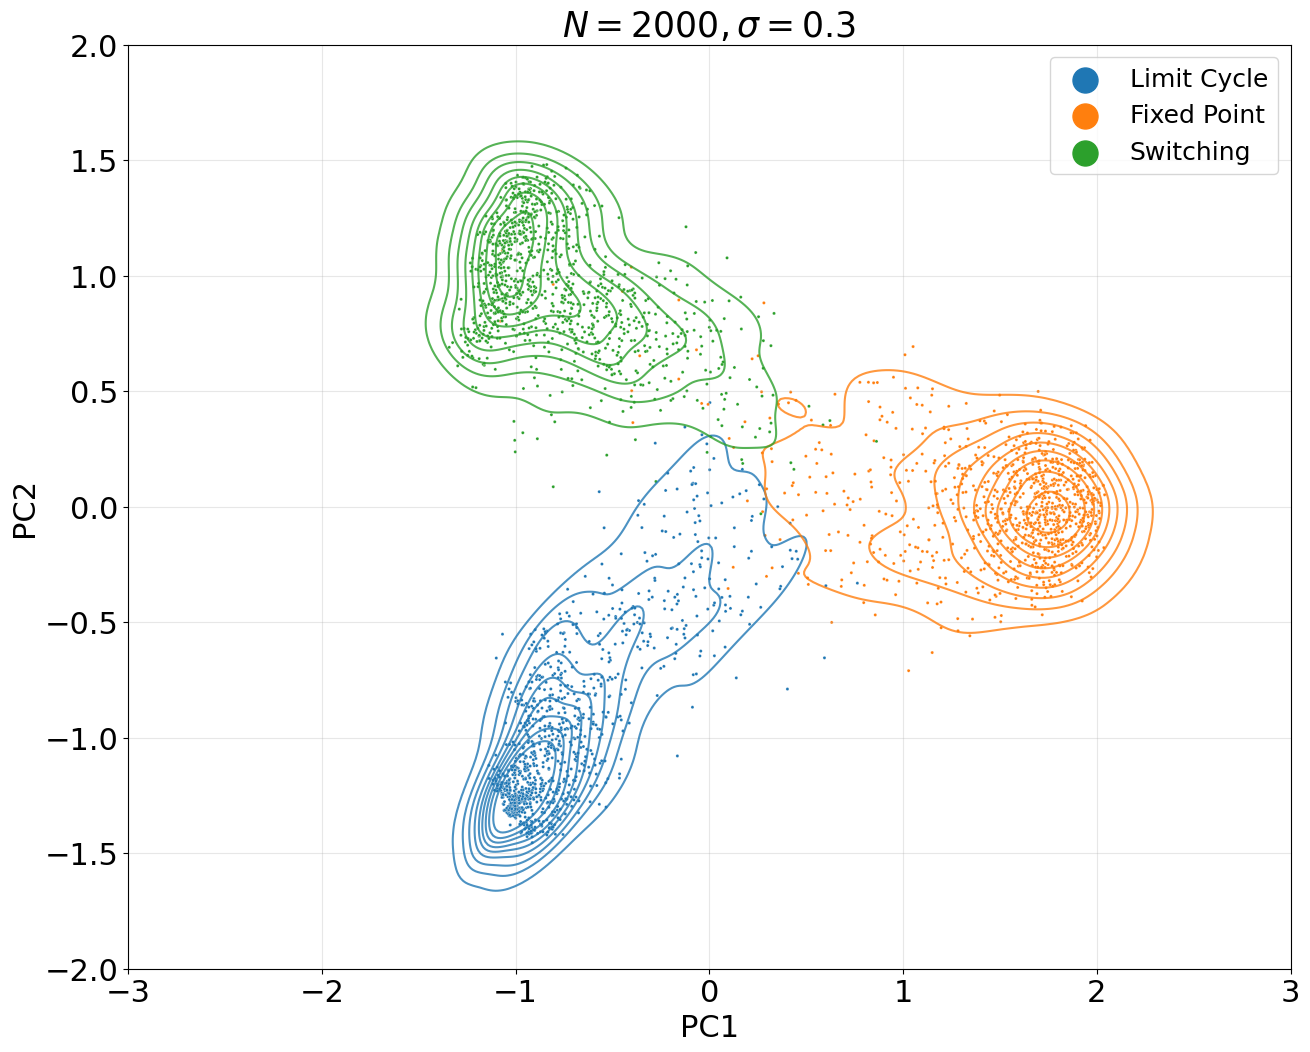

In [148]:
plt.figure(figsize=(15,12))
plt.grid(alpha=0.3)
sns.kdeplot(x=pca[:,0], y=pca[:,1], levels=10, hue=df_combined_regimes['regime'], alpha=0.8)
sns.scatterplot(x=pca[:,0], y=pca[:,1], s=5, hue=df_combined_regimes['regime'])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('PC1', fontsize=22)
plt.ylabel('PC2', fontsize=22)
plt.title('$N = 2000, \sigma = 0.3$', fontsize=25)
plt.legend(markerscale=3, fontsize=18)
plt.xlim(-3, 3)
plt.ylim(-2, 2)
plt.savefig('low_noise_alt_sampling.svg', dpi=420, transparent=True)

In [157]:
df_combined_regimes[df_combined_regimes['regime'] == 'Switching']

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,N,mu,eta,model,regime
1999,-0.976702,-1.133138,458.785030,1081.0,1.213797,-0.000006,0.280140,984.0,0.166667,0.0,...,1.320368,0.122449,0.326531,0.003068,0.046929,2000,-0.296075,0.3,Bistable,Switching
2000,-0.775167,-0.590830,291.479812,621.0,1.000942,-0.000003,0.376688,534.0,0.062500,0.0,...,1.357587,0.877551,0.795918,0.003068,0.056293,2000,-0.302115,0.3,Bistable,Switching
2001,-0.785709,-0.618499,305.881215,699.0,0.954473,-0.000003,0.290645,533.0,0.074074,0.0,...,1.354148,0.877551,0.795918,0.003068,0.047112,2000,-0.277321,0.3,Bistable,Switching
2002,-0.991653,-0.843923,428.321877,1070.0,1.209927,-0.000005,0.242121,899.0,0.166667,0.0,...,1.276627,0.877551,0.816327,0.003068,0.042382,2000,-0.232255,0.3,Bistable,Switching
2003,-0.877717,-0.723668,410.369393,1097.0,1.131095,-0.000004,0.307654,669.0,0.074074,421.0,...,1.253524,0.122449,0.877551,0.003068,0.048535,2000,-0.222769,0.3,Bistable,Switching
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,-0.731070,-0.577605,362.692847,837.0,1.081346,-0.000004,0.263632,662.0,0.074074,0.0,...,1.281050,0.122449,0.877551,0.003068,0.044078,2000,-0.283832,0.3,Bistable,Switching
2995,-0.870645,-0.710371,383.298098,849.0,1.081215,-0.000008,0.308654,732.0,0.074074,653.0,...,1.306779,0.122449,0.877551,0.003068,0.047879,2000,-0.226035,0.3,Bistable,Switching
2996,-1.142452,-0.976428,433.276362,1044.0,1.274882,-0.000003,0.311656,992.0,0.166667,0.0,...,1.243837,0.122449,0.877551,0.003068,0.049257,2000,-0.180816,0.3,Bistable,Switching
2997,-0.863648,-0.682536,267.352771,575.0,1.048690,-0.000015,0.364682,510.0,0.062500,0.0,...,1.374644,0.877551,0.775510,0.006136,0.056878,2000,-0.338071,0.3,Bistable,Switching


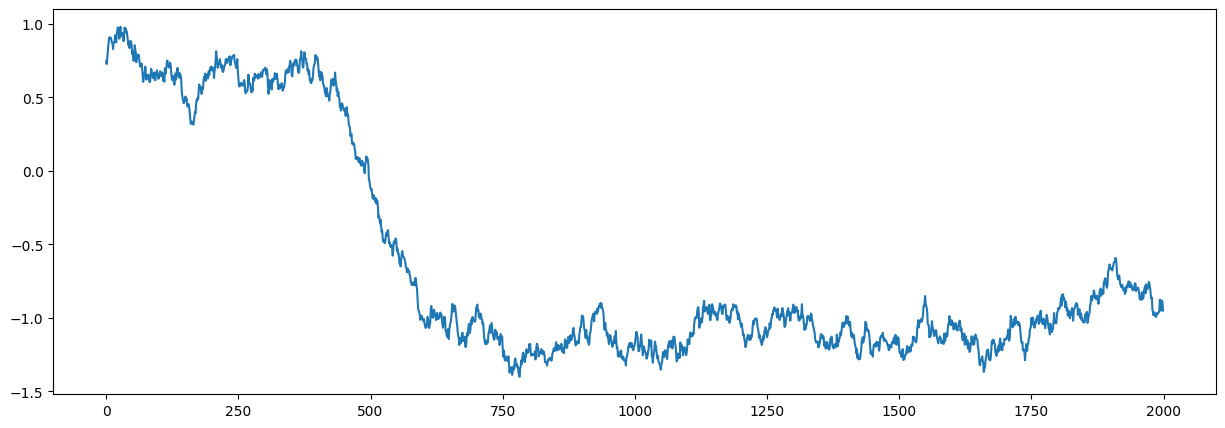

In [161]:
plt.figure(figsize=(15,5))
plt.plot(ts_combined_regimes[2005])
plt.savefig('N2000SIG03_bs_sw.svg', transparent=True)

In [163]:
replace_values = {'Hookes Fixed Point' : 'Fixed Point', 
                  'Bistable Fixed Point' : 'Fixed Point',
                  'Hopf Fixed Point' : 'Fixed Point',
                  'Hopf Limit Cycle' : 'Limit Cycle',
                  'Bistable Switching' : 'Switching'}
df_combined_regimes['behaviour'] = df_combined_regimes['regime'].replace(replace_values)

In [164]:
df_normalised = pd.DataFrame(xhat)
df_normalised['regime'] = df_combined_regimes['regime']
df_normalised['behaviour'] = df_combined_regimes['behaviour']
df_normalised['N'] = df_combined_regimes['N']
df_normalised['mu'] = df_combined_regimes['mu']
df_normalised['eta'] = df_combined_regimes['eta']

In [165]:
df_normalised['behaviour'].value_counts()

Limit Cycle    1000
Switching      1000
Fixed Point     999
Name: behaviour, dtype: int64

# Load Point 

In [166]:
df_xhat_limit_cycle = df_normalised[df_normalised['behaviour'] == 'Limit Cycle'].drop(columns={'regime', 'behaviour', 'N', 'mu', 'eta'})
df_xhat_fixed_point = df_normalised[df_normalised['behaviour'] == 'Fixed Point'].drop(columns={'regime', 'behaviour', 'N', 'mu', 'eta'})
df_xhat_switching = df_normalised[df_normalised['behaviour'] == 'Switching'].drop(columns={'regime', 'behaviour', 'N', 'mu', 'eta'})

In [167]:
## within class distances
dist_within_limit_cycle = pairwise_distances(df_xhat_limit_cycle, metric='euclidean')
dist_within_fixed_point = pairwise_distances(df_xhat_fixed_point, metric='euclidean')
dist_within_switching = pairwise_distances(df_xhat_switching, metric='euclidean')

# remove double counting
dist_within_limit_cycle = dist_within_limit_cycle[np.triu_indices(dist_within_limit_cycle.shape[0], k=1)]
dist_within_fixed_point = dist_within_fixed_point[np.triu_indices(dist_within_fixed_point.shape[0], k=1)]
dist_within_switching = dist_within_switching[np.triu_indices(dist_within_switching.shape[0], k=1)]


In [168]:
## between class distances
limit_cycle_to_fixed_point = pairwise_distances(df_xhat_limit_cycle, df_xhat_fixed_point, metric='euclidean').flatten()
limit_cycle_to_switching = pairwise_distances(df_xhat_limit_cycle, df_xhat_switching, metric='euclidean').flatten()
fixed_point_to_switching = pairwise_distances(df_xhat_fixed_point, df_xhat_switching, metric='euclidean').flatten()

In [169]:
## Now combine within class (regime) and between class (regime) distances
within_class = np.concatenate([dist_within_limit_cycle, dist_within_fixed_point, dist_within_switching])
between_class = np.concatenate([limit_cycle_to_fixed_point, limit_cycle_to_switching, fixed_point_to_switching])


In [170]:
def select_epsilon(within_class_dists, between_class_dists):
    all_dists = np.concatenate((within_class_dists, between_class_dists))
    # create lables to specify between or within class dist
    labels = np.concatenate([np.zeros_like(within_class_dists), np.ones_like(between_class_dists)]) # 0 = within, 1 = between
    fpr, tpr, thresh = roc_curve(labels, all_dists)

    # find area under curve
    roc_auc = auc(fpr, tpr)

    # find the optimal threshold which maximises true positive rate and minimises false positive rate (i.e. TPR-FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresh[optimal_idx]
    
    return fpr, tpr, roc_auc, optimal_threshold

In [171]:
fpr, tpr, roc_auc, optimal_threshold = select_epsilon(within_class, between_class)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

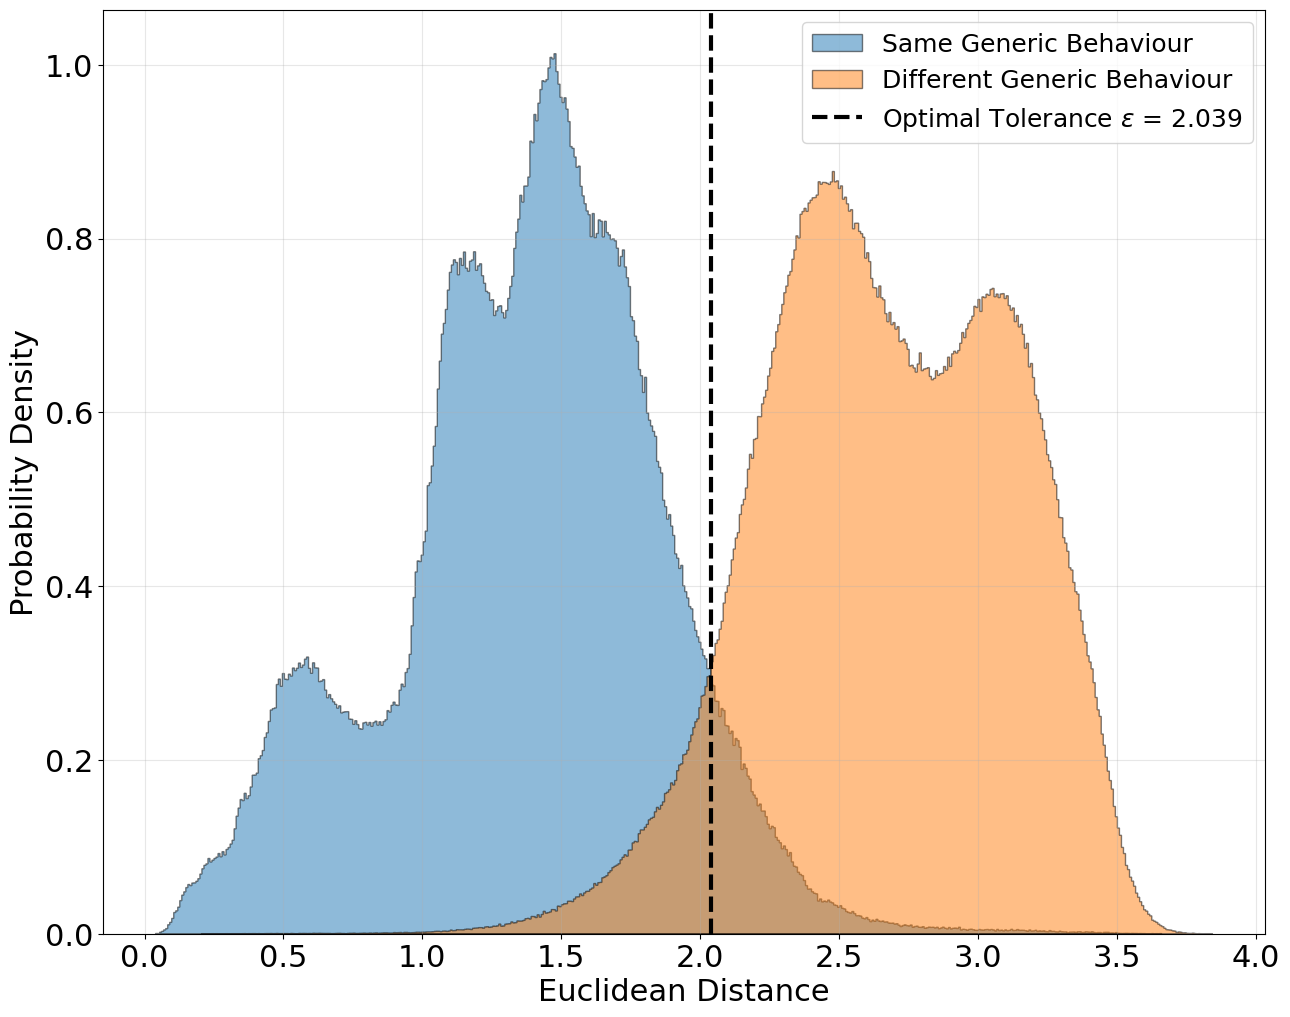

In [172]:
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)
plt.hist(within_class, bins=500, alpha=0.5, label='Same Generic Behaviour', density=True, edgecolor='k', histtype='stepfilled')
plt.hist(between_class, bins=500, alpha=0.5, label='Different Generic Behaviour', density=True, edgecolor='k', histtype='stepfilled')
plt.axvline(optimal_threshold, color='k', linestyle='dashed', linewidth=3, label='Optimal Tolerance $\epsilon$ = {}'.format(np.round(optimal_threshold, 3)))
plt.legend(fontsize=18)
plt.xlabel('Euclidean Distance', fontsize=22)
plt.ylabel('Probability Density', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

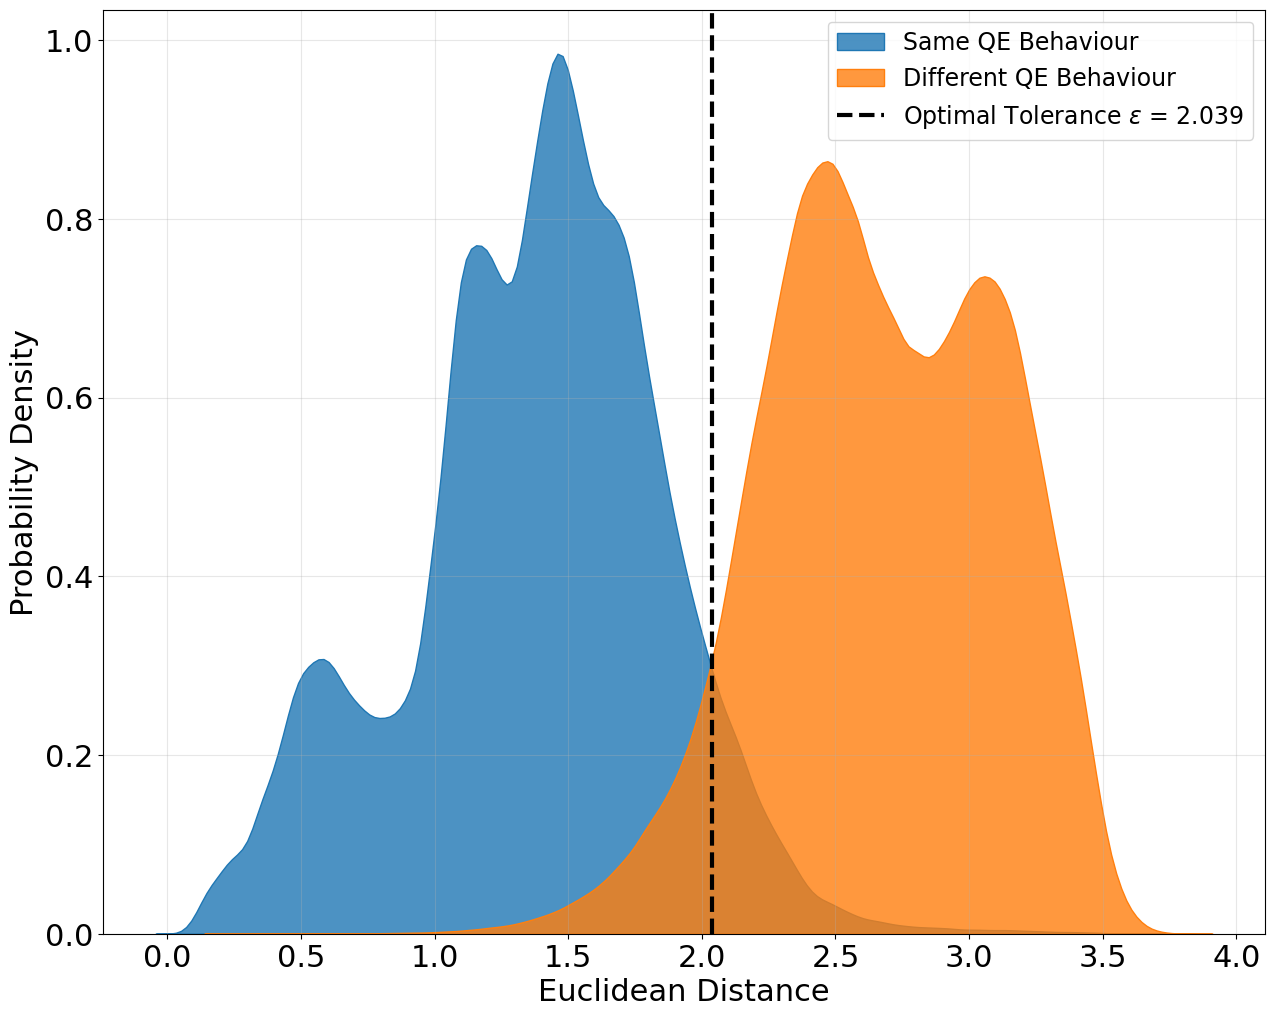

In [174]:
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)
sns.kdeplot(x=within_class, label='Same QE Behaviour', fill=True, alpha=0.8)
sns.kdeplot(x=between_class, label='Different QE Behaviour', fill=True, alpha=0.8)
plt.axvline(optimal_threshold, color='k', linestyle='dashed', linewidth=3, label='Optimal Tolerance $\epsilon$ = {}'.format(np.round(optimal_threshold, 3)))
plt.legend(fontsize=17)
plt.xlabel('Euclidean Distance', fontsize=22)
plt.ylabel('Probability Density', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.savefig('low_noise_alt_sampling_kde.png', dpi=420, transparent=True)

In [175]:
abc = RadiusNeighborsClassifier(radius=optimal_threshold, outlier_label='most_frequent')
abc.fit(df_normalised.iloc[:,:22], df_normalised['behaviour'])

RadiusNeighborsClassifier(outlier_label='most_frequent',
                          radius=2.0385982451409386)

In [75]:
ts_lc_test, df_lc_test = gen_limitCycle(200, N_fixed=2000, eta_fixed=0.3)
ts_fp_test, df_fp_test = gen_fixedpoint(200, N_fixed=2000, eta_fixed=0.3)
ts_sw_test, df_sw_test = gen_switching(200, N_fixed=2000, eta_fixed=0.3)

In [176]:
df_test = pd.concat([df_lc_test, df_fp_test, df_sw_test], ignore_index=True)
xhat_test = mm.transform(sigmoid_transformer.transform(rs.transform(df_test.iloc[:,:22])))

C:\Users\Joshua\AppData\Local\Temp\ipykernel_3368\1228224673.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta*x))


In [177]:
ts_test = ts_lc_test + ts_fp_test + ts_sw_test

In [178]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,N,mu,eta,model,regime
0,1.197599,1.351178,123.550285,323.0,1.458446,1.738923e-07,0.105553,359.0,0.013774,648.0,...,1.182637,0.857143,0.795918,0.009204,0.034135,2000,3.741123,0.3,Hopf,Limit Cycle
1,1.131208,1.281428,115.790531,307.0,1.429843,6.999523e-07,0.069535,323.0,0.039352,624.0,...,1.157304,0.836735,0.755102,0.009204,0.030670,2000,4.730767,0.3,Hopf,Limit Cycle
2,1.176429,1.019160,106.348260,285.0,1.366659,-4.125414e-06,0.236118,342.0,0.017751,577.0,...,1.198188,0.857143,0.714286,0.012272,0.045697,2000,1.693120,0.3,Hopf,Limit Cycle
3,1.102711,1.250400,111.429418,293.0,1.433730,-9.929772e-07,0.071536,291.0,0.017751,594.0,...,1.174009,0.857143,0.755102,0.009204,0.031801,2000,4.967296,0.3,Hopf,Limit Cycle
4,1.077421,1.224586,115.964458,306.0,1.400352,-1.325797e-07,0.071036,308.0,0.039352,630.0,...,1.167621,0.857143,0.734694,0.009204,0.030968,2000,4.877659,0.3,Hopf,Limit Cycle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,-0.933316,-0.787014,407.758126,1135.0,1.128055,-5.865140e-06,0.241121,867.0,0.111111,658.0,...,1.332853,0.122449,0.877551,0.003068,0.043098,2000,-0.207321,0.3,Bistable,Switching
594,0.858663,0.711810,374.004452,1293.0,1.046282,-6.812700e-07,0.219110,1284.0,0.111111,603.0,...,1.279832,0.142857,0.877551,0.003068,0.040271,2000,-0.081649,0.3,Bistable,Switching
595,0.982966,0.413058,323.977388,840.0,1.274967,-1.475905e-05,0.342171,1265.0,0.111111,0.0,...,1.216079,0.122449,0.877551,0.003068,0.051470,2000,-0.245776,0.3,Bistable,Switching
596,-0.649120,-0.487784,273.318257,571.0,0.870233,-3.446820e-06,0.320160,512.0,0.062500,560.0,...,1.414121,0.877551,0.795918,0.003068,0.049788,2000,-0.378051,0.3,Bistable,Switching


In [31]:
colors = sns.color_palette('Set1')

(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

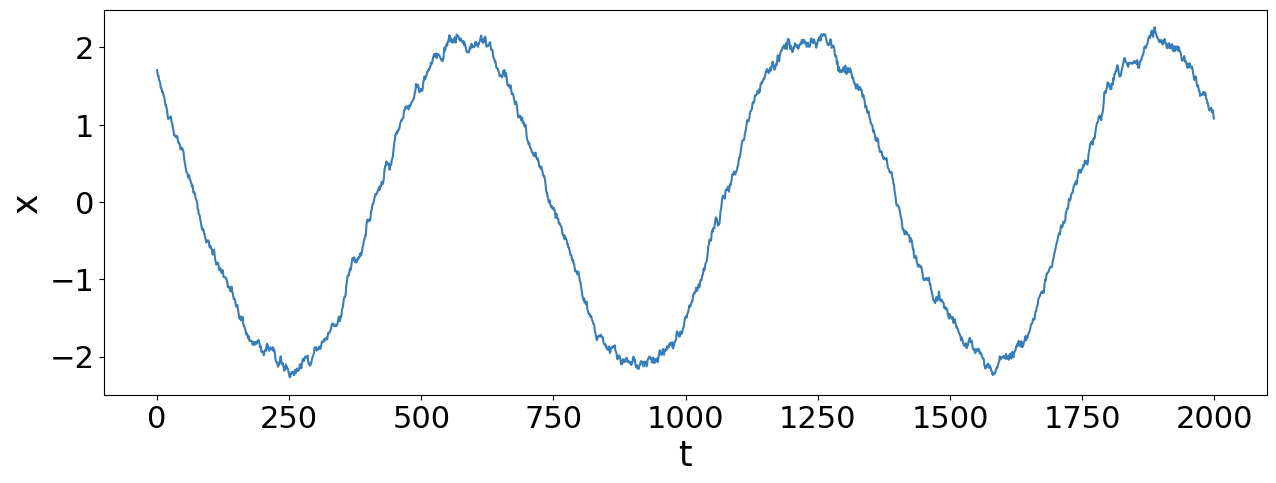

In [45]:
plt.figure(figsize=(15, 5))
plt.plot(ts_test[0], color=colors[1])
plt.xlabel('t', fontsize=25)
plt.ylabel('x', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.savefig('N200SIG03_hlc.svg', transparent=True)

In [179]:
posterior = abc.predict_proba(xhat_test)

In [180]:
classes = abc.classes_

In [181]:
classes

array(['Fixed Point', 'Limit Cycle', 'Switching'], dtype=object)

In [182]:
posterior

array([[0.00104384, 0.98956159, 0.00939457],
       [0.00105263, 0.99263158, 0.00631579],
       [0.02868069, 0.94646272, 0.0248566 ],
       ...,
       [0.01780415, 0.03956479, 0.94263106],
       [0.03463855, 0.24548193, 0.71987952],
       [0.36902928, 0.06086287, 0.57010786]])

In [183]:
df_post = pd.DataFrame(posterior, columns=[classes[0], classes[1], classes[2]])
df_post['ground_truth'] = df_test['regime']

In [184]:
df_post

,Fixed Point,Limit Cycle,Switching,ground_truth
0,0.001044,0.989562,0.009395,Limit Cycle
1,0.001053,0.992632,0.006316,Limit Cycle
2,0.028681,0.946463,0.024857,Limit Cycle
3,0.001057,0.998943,0.000000,Limit Cycle
4,0.001059,0.996822,0.002119,Limit Cycle
...,...,...,...,...
593,0.013889,0.023810,0.962302,Switching
594,0.016362,0.072185,0.911453,Switching
595,0.017804,0.039565,0.942631,Switching
596,0.034639,0.245482,0.719880,Switching


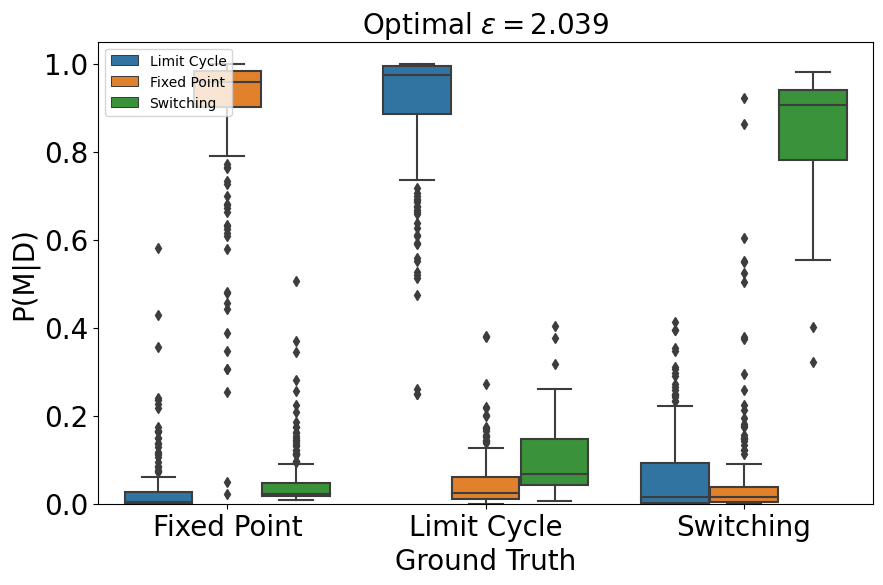

In [270]:
df_melted = df_post.melt(id_vars='ground_truth', var_name='Model', value_name='Predicted probability')

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Predicted probability', hue='ground_truth', data=df_melted)
plt.title('Optimal $\epsilon = {}$'.format(np.round(optimal_threshold, 3)), fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Ground Truth', fontsize=20)
plt.ylabel('P(M|D)', fontsize=20)
plt.legend(loc='upper left')
plt.ylim(0, 1.05)
plt.savefig('lowNoise_highN.svg', transparent=True)
#plt.show()

(0.0, 1.0)

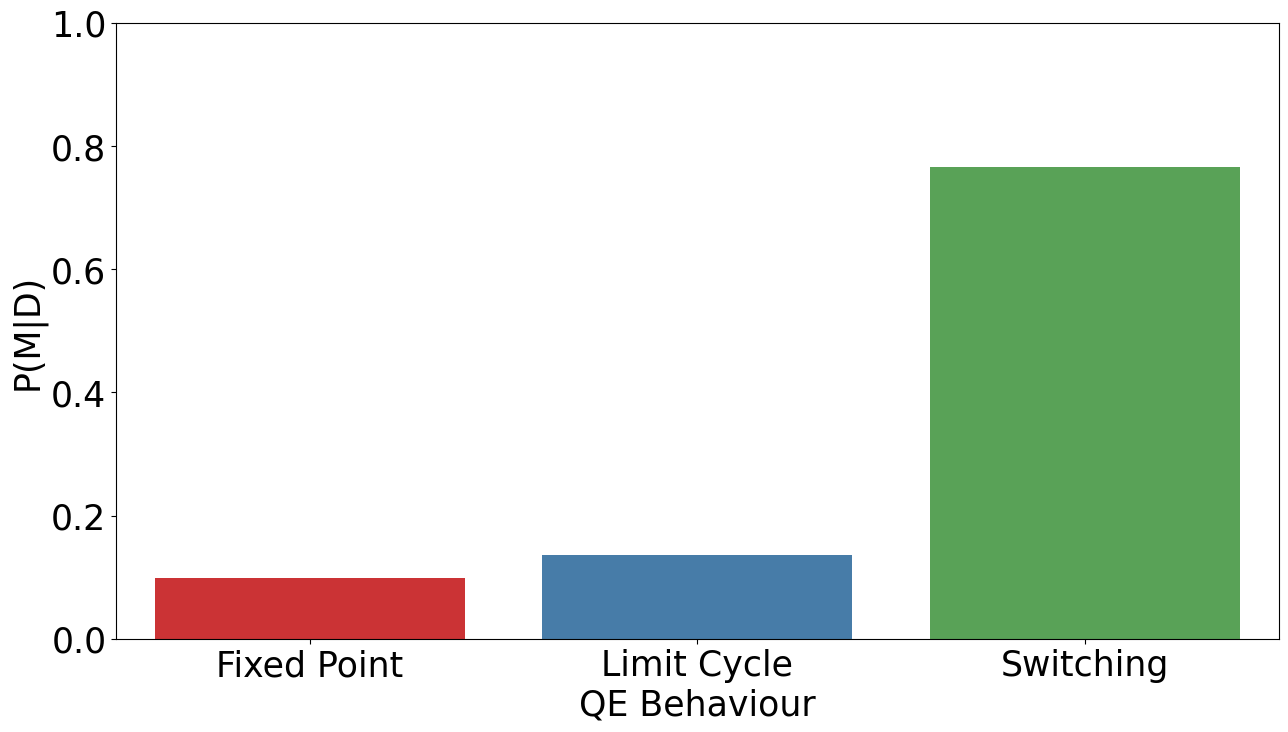

In [38]:
plt.style.use('default')
plt.figure(figsize=(15, 8))
sns.barplot(x=classes, y=posterior[4], palette='Set1', orient='v')
plt.ylabel('P(M|D)', fontsize=25)
plt.xlabel('QE Behaviour', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0, 1)
#plt.savefig('low_noise_alt_sampling_posterior_sw.svg', transparent=True)

In [87]:
ts_lc_med_sig_high_N, df_lc_med_sig_high_N = gen_limitCycle(1000,  N_fixed=200, eta_fixed=1)
ts_fp_med_sig_high_N, df_fp_med_sig_high_N = gen_fixedpoint(1000, N_fixed=200, eta_fixed=1)
ts_sw_med_sig_high_N, df_sw_med_sig_high_N = gen_switching(1000, N_fixed=200, eta_fixed=1)

In [188]:
df_combined_regimes2 = pd.concat([df_lc_med_sig_high_N, df_fp_med_sig_high_N, df_sw_med_sig_high_N], ignore_index=True)
ts_combined_regimes2 = ts_lc_med_sig_high_N + ts_fp_med_sig_high_N + ts_sw_med_sig_high_N

In [189]:
rs2 = RobustScaler().fit(df_combined_regimes2.iloc[:,:22])
rs_fit2 = rs2.transform(df_combined_regimes2.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer2 = FunctionTransformer(sigmoid, kw_args={'theta': 3})
sigmoid_transformer2.fit(rs_fit)
sigmoid_fit2 = sigmoid_transformer2.transform(rs_fit2)
mm2 = MinMaxScaler().fit(sigmoid_fit2)
mm_fit2 = mm2.transform(sigmoid_fit2)
xhat2 = mm_fit2

In [190]:
pca_fit = PCA(n_components=2).fit(mm_fit2)
pca = pca_fit.transform(mm_fit2)

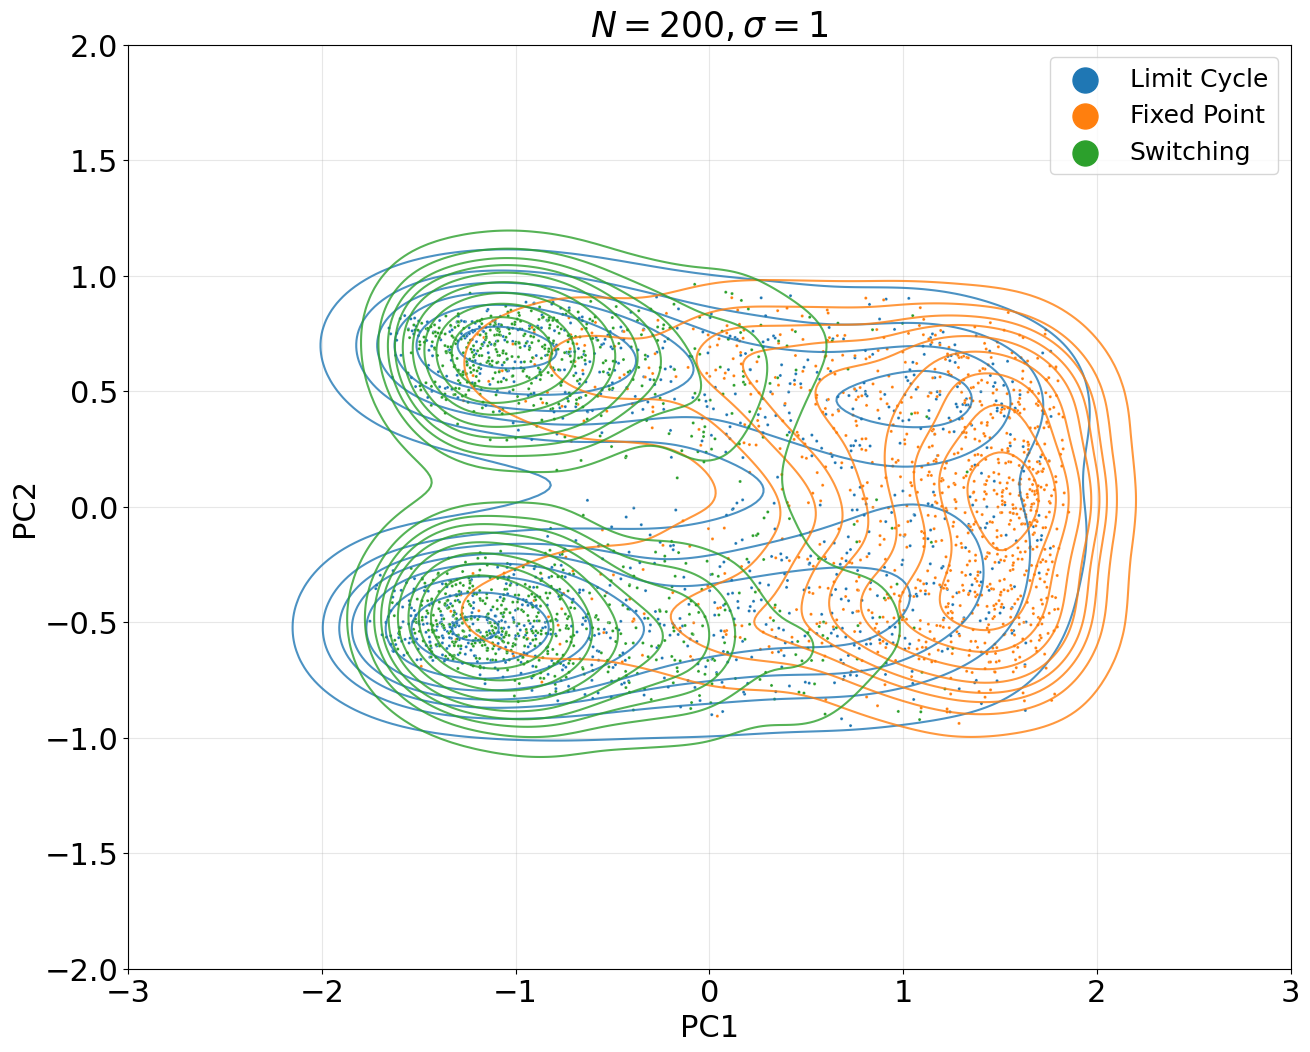

In [193]:
plt.figure(figsize=(15,12))
plt.grid(alpha=0.3)
sns.kdeplot(x=pca[:,0], y=pca[:,1], levels=10, hue=df_combined_regimes2['regime'], alpha=0.8)
sns.scatterplot(x=pca[:,0], y=pca[:,1], s=5, hue=df_combined_regimes2['regime'])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('PC1', fontsize=22)
plt.ylabel('PC2', fontsize=22)
plt.title('$N = 200, \sigma = 1$', fontsize=25)
plt.legend(markerscale=3, fontsize=18)
plt.xlim(-3, 3)
plt.ylim(-2, 2)
plt.savefig('high_noise_Low_N_alt_sampling.png', dpi=420, transparent=True)

In [215]:
df_combined_regimes2[df_combined_regimes2['regime'] == 'Fixed Point']

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,N,mu,eta,model,regime,behaviour
1000,0.867124,0.633417,19.802365,62.0,0.612046,-0.004704,0.914573,45.0,0.062500,43.0,...,0.857143,0.857143,0.049087,0.360613,200,-2.885916,1,Hookes,Fixed Point,Fixed Point
1001,-0.719867,-0.103348,19.278572,31.0,0.623021,0.000218,0.909548,61.0,0.062500,54.0,...,0.142857,0.857143,0.049087,0.358344,200,-4.890516,1,Hookes,Fixed Point,Fixed Point
1002,-0.607926,-0.809857,34.475954,100.0,0.861306,-0.000256,0.824121,75.0,0.111111,40.0,...,0.595238,0.785714,0.024544,0.202629,200,-0.037081,1,Hookes,Fixed Point,Fixed Point
1003,0.179834,0.811991,15.536315,27.0,0.600186,-0.001081,0.884422,36.0,0.040000,60.0,...,0.142857,0.738095,0.073631,0.424616,200,-2.683890,1,Hookes,Fixed Point,Fixed Point
1004,0.218017,0.408399,35.840883,97.0,0.972509,0.000151,0.814070,91.0,0.074074,0.0,...,0.166667,0.857143,0.024544,0.197035,200,-2.379039,1,Hookes,Fixed Point,Fixed Point
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,-0.707338,0.771689,16.966906,12.0,0.523652,-0.008488,0.929648,37.0,0.166667,13.0,...,0.833333,0.833333,0.098175,0.526399,200,-3.597835,1,Bistable,Fixed Point,Fixed Point
1995,-0.152352,0.081274,16.382797,13.0,0.450304,0.024787,0.944724,35.0,0.027211,14.0,...,0.833333,0.738095,0.073631,0.520843,200,-4.194823,1,Bistable,Fixed Point,Fixed Point
1996,0.107808,-0.119837,7.088740,15.0,0.462100,0.025319,0.919598,22.0,0.002963,46.0,...,0.404762,0.833333,0.147262,0.519592,200,3.881792,1,Bistable,Fixed Point,Fixed Point
1997,0.142042,0.415226,5.610852,12.0,0.368267,0.011488,0.899497,27.0,0.049383,26.0,...,0.261905,0.261905,0.196350,0.613544,200,-3.125381,1,Bistable,Fixed Point,Fixed Point


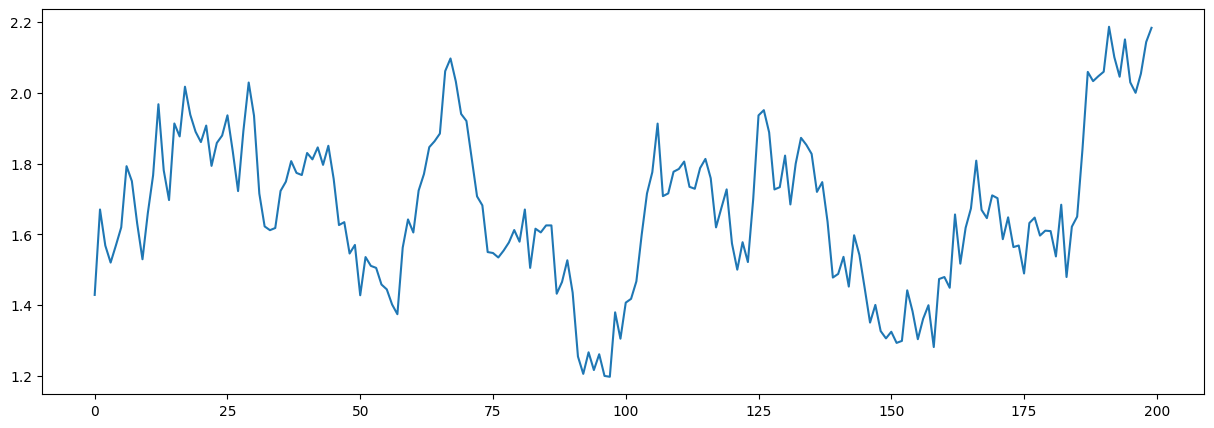

In [217]:
plt.figure(figsize=(15,5))
plt.plot(ts_combined_regimes2[1996])
plt.savefig('N200SIG1_h_fp.svg', transparent=True)

In [218]:
replace_values = {'Hookes Fixed Point' : 'Fixed Point', 
                  'Bistable Fixed Point' : 'Fixed Point',
                  'Hopf Fixed Point' : 'Fixed Point',
                  'Hopf Limit Cycle' : 'Limit Cycle',
                  'Bistable Switching' : 'Switching'}
df_combined_regimes2['behaviour'] = df_combined_regimes2['regime'].replace(replace_values)

In [219]:
df_normalised2 = pd.DataFrame(xhat2)
df_normalised2['regime'] = df_combined_regimes2['regime']
df_normalised2['behaviour'] = df_combined_regimes2['behaviour']
df_normalised2['N'] = df_combined_regimes2['N']
df_normalised2['mu'] = df_combined_regimes2['mu']
df_normalised2['eta'] = df_combined_regimes2['eta']

In [220]:
df_normalised2['behaviour'].value_counts()

Limit Cycle    1000
Switching      1000
Fixed Point     999
Name: behaviour, dtype: int64

In [221]:
df_xhat_limit_cycle2 = df_normalised2[df_normalised2['behaviour'] == 'Limit Cycle'].drop(columns={'regime', 'behaviour', 'N', 'mu', 'eta'})
df_xhat_fixed_point2 = df_normalised2[df_normalised2['behaviour'] == 'Fixed Point'].drop(columns={'regime', 'behaviour', 'N', 'mu', 'eta'})
df_xhat_switching2 = df_normalised2[df_normalised2['behaviour'] == 'Switching'].drop(columns={'regime', 'behaviour', 'N', 'mu', 'eta'})

In [222]:
## within class distances
dist_within_limit_cycle2 = pairwise_distances(df_xhat_limit_cycle2, metric='euclidean')
dist_within_fixed_point2 = pairwise_distances(df_xhat_fixed_point2, metric='euclidean')
dist_within_switching2 = pairwise_distances(df_xhat_switching2, metric='euclidean')

# remove double counting
dist_within_limit_cycle2 = dist_within_limit_cycle2[np.triu_indices(dist_within_limit_cycle2.shape[0], k=1)]
dist_within_fixed_point2 = dist_within_fixed_point2[np.triu_indices(dist_within_fixed_point2.shape[0], k=1)]
dist_within_switching2 = dist_within_switching2[np.triu_indices(dist_within_switching2.shape[0], k=1)]

In [223]:
## between class distances
limit_cycle_to_fixed_point2 = pairwise_distances(df_xhat_limit_cycle2, df_xhat_fixed_point2, metric='euclidean').flatten()
limit_cycle_to_switching2 = pairwise_distances(df_xhat_limit_cycle2, df_xhat_switching2, metric='euclidean').flatten()
fixed_point_to_switching2 = pairwise_distances(df_xhat_fixed_point2, df_xhat_switching2, metric='euclidean').flatten()

In [224]:
## Now combine within class (regime) and between class (regime) distances
within_class2 = np.concatenate([dist_within_limit_cycle2, dist_within_fixed_point2, dist_within_switching2])
between_class2 = np.concatenate([limit_cycle_to_fixed_point2, limit_cycle_to_switching2, fixed_point_to_switching2])

In [201]:
fpr2, tpr2, roc_auc2, optimal_threshold2 = select_epsilon(within_class2, between_class2)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

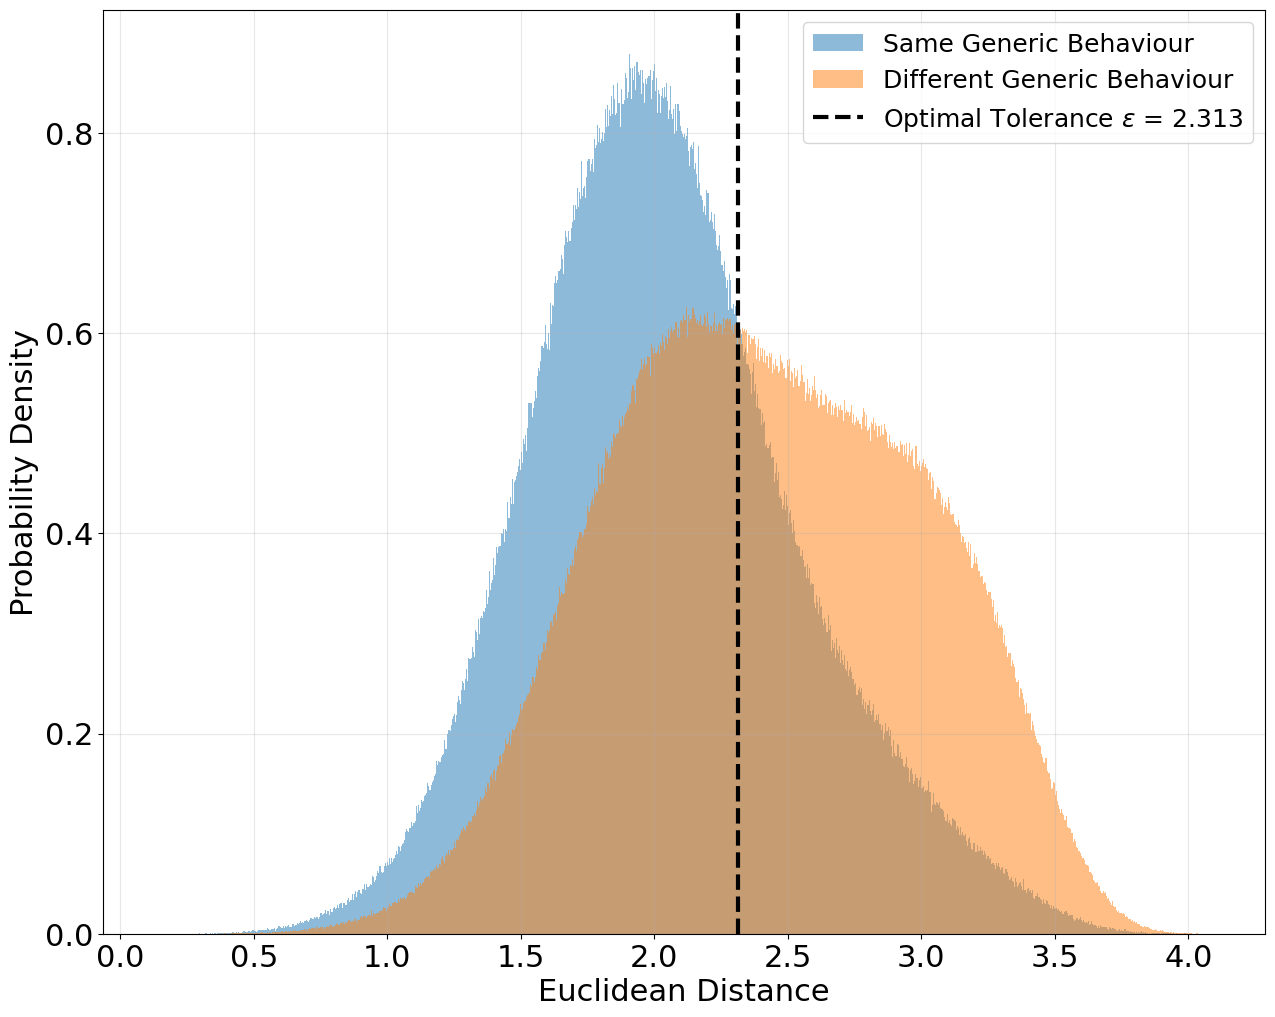

In [113]:
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)
plt.hist(within_class2, bins=1000, alpha=0.5, label='Same Generic Behaviour', density=True)
plt.hist(between_class2, bins=1000, alpha=0.5, label='Different Generic Behaviour', density=True)
plt.axvline(optimal_threshold2, color='k', linestyle='dashed', linewidth=3, label='Optimal Tolerance $\epsilon$ = {}'.format(np.round(optimal_threshold2, 3)))
plt.legend(fontsize=18)
plt.xlabel('Euclidean Distance', fontsize=22)
plt.ylabel('Probability Density', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

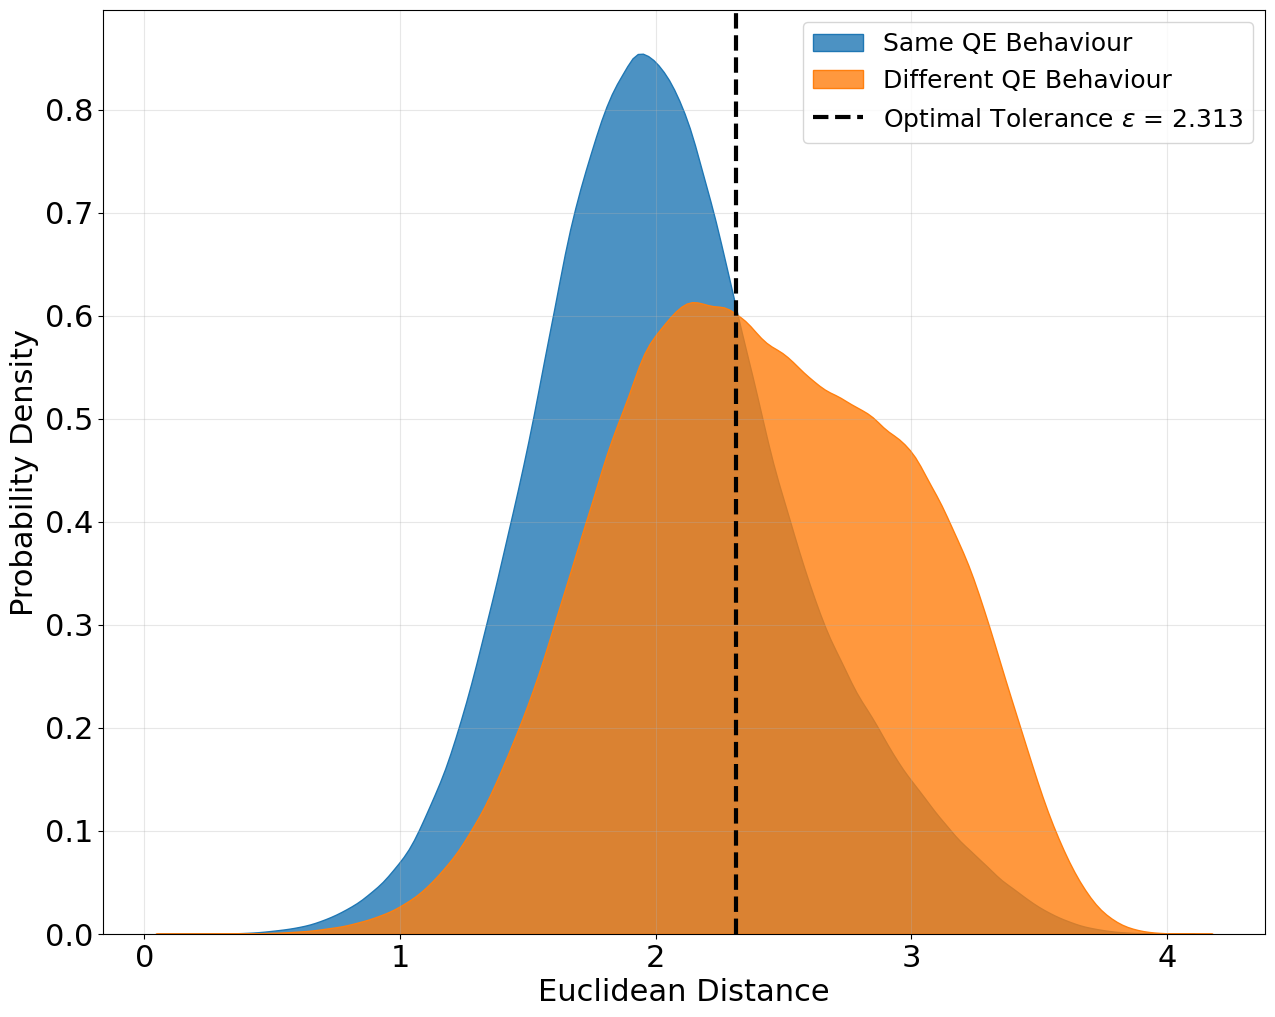

In [226]:
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)
sns.kdeplot(x=within_class2, label='Same QE Behaviour', fill=True, alpha=0.8)
sns.kdeplot(x=between_class2, label='Different QE Behaviour', fill=True, alpha=0.8)
plt.axvline(optimal_threshold2, color='k', linestyle='dashed', linewidth=3, label='Optimal Tolerance $\epsilon$ = {}'.format(np.round(optimal_threshold2, 3)))
plt.legend(fontsize=18)
plt.xlabel('Euclidean Distance', fontsize=22)
plt.ylabel('Probability Density', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.savefig('high_noise_low_N_sampling_kde.png', dpi=420, transparent=True)

In [225]:
abc2 = RadiusNeighborsClassifier(radius=optimal_threshold2, outlier_label='most_frequent')
abc2.fit(df_normalised2.iloc[:,:22], df_normalised2['behaviour'])

RadiusNeighborsClassifier(outlier_label='most_frequent',
                          radius=2.3134965457208176)

In [102]:
ts_lc_test2, df_lc_test2 = gen_limitCycle(200, N_fixed=200, eta_fixed=1)
ts_fp_test2, df_fp_test2 = gen_fixedpoint(200, N_fixed=200, eta_fixed=1)
ts_sw_test2, df_sw_test2 = gen_switching(200, N_fixed=200, eta_fixed=1)

In [227]:
df_test2 = pd.concat([df_lc_test2, df_fp_test2, df_sw_test2], ignore_index=True)
xhat_test2 = mm2.transform(sigmoid_transformer2.transform(rs2.transform(df_test2.iloc[:,:22])))

In [228]:
ts_test2 = ts_lc_test2 + ts_fp_test2 + ts_sw_test2

In [229]:
df_test2

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,N,mu,eta,model,regime
0,-0.675177,-0.868377,42.609160,123.0,0.886681,-0.001005,0.804020,96.0,0.111111,19.0,...,1.357660,0.857143,0.809524,0.024544,0.215502,200,1.525534,1,Hopf,Limit Cycle
1,-0.762405,-0.963779,24.550972,69.0,0.769443,-0.000882,0.844221,98.0,0.041667,0.0,...,1.476512,0.261905,0.857143,0.049087,0.255917,200,0.289821,1,Hopf,Limit Cycle
2,0.972615,0.754985,29.655649,109.0,0.940542,0.000152,0.768844,93.0,0.166667,47.0,...,1.390233,0.452381,0.738095,0.024544,0.180198,200,4.606785,1,Hopf,Limit Cycle
3,-0.514215,-0.704348,35.980347,82.0,0.784527,-0.001037,0.834171,71.0,0.074074,15.0,...,1.523729,0.857143,0.738095,0.024544,0.231952,200,1.774736,1,Hopf,Limit Cycle
4,0.505401,0.713369,12.437056,37.0,0.632371,0.002730,0.904523,48.0,0.036458,53.0,...,1.658421,0.857143,0.595238,0.098175,0.394175,200,1.850971,1,Hopf,Limit Cycle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,-0.654856,-0.446561,29.975580,80.0,0.892565,0.000152,0.768844,74.0,0.074074,33.0,...,1.533535,0.857143,0.738095,0.024544,0.161520,200,-0.040959,1,Bistable,Switching
594,-0.600083,0.174277,30.398662,77.0,1.093224,0.001678,0.814070,86.0,0.062500,49.0,...,1.398212,0.833333,0.857143,0.049087,0.195272,200,-0.243185,1,Bistable,Switching
595,-0.480576,-1.016136,37.671833,83.0,0.951736,0.000352,0.753769,76.0,0.111111,50.0,...,1.423670,0.142857,0.738095,0.024544,0.159552,200,-0.208890,1,Bistable,Switching
596,-1.237467,-1.049910,31.322390,99.0,0.883702,-0.000029,0.773869,58.0,0.111111,40.0,...,1.602104,0.857143,0.738095,0.024544,0.211538,200,0.062893,1,Bistable,Switching


In [ ]:
colors = sns.color_palette('Set1')

(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

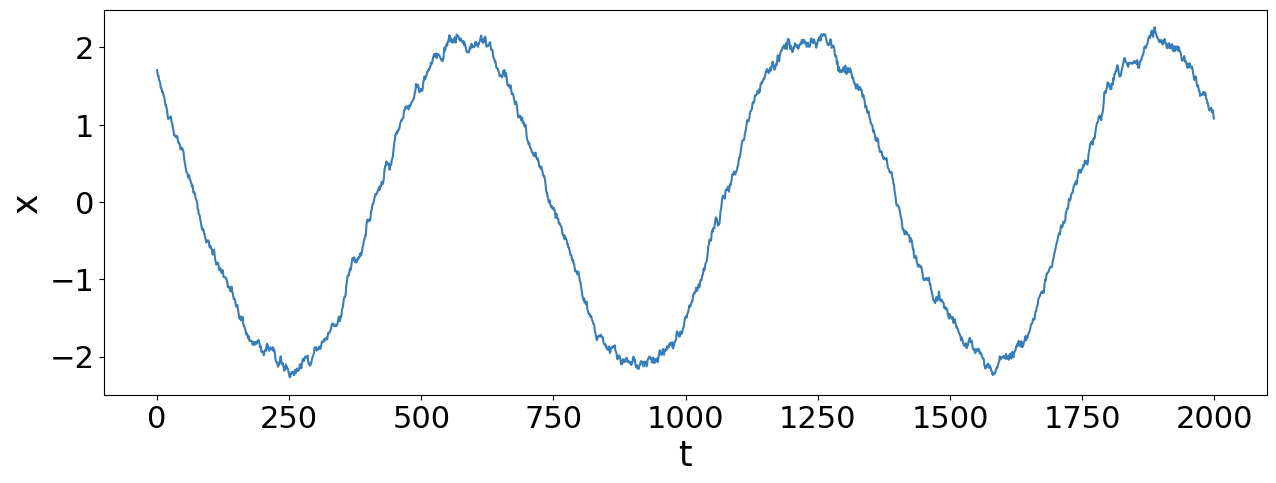

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(ts_test[0], color=colors[1])
plt.xlabel('t', fontsize=25)
plt.ylabel('x', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.savefig('N200SIG03_hlc.svg', transparent=True)

In [230]:
posterior2 = abc2.predict_proba(xhat_test2)

In [231]:
classes2 = abc2.classes_

In [232]:
classes

array(['Fixed Point', 'Limit Cycle', 'Switching'], dtype=object)

In [127]:
posterior2

array([[0.11683643, 0.38346315, 0.49970042],
       [0.33935243, 0.33250311, 0.32814446],
       [0.08810844, 0.37769563, 0.53419593],
       ...,
       [0.10538373, 0.37399771, 0.52061856],
       [0.1718908 , 0.36754297, 0.46056623],
       [0.11256831, 0.38251366, 0.50491803]])

In [233]:
df_post2 = pd.DataFrame(posterior2, columns=[classes2[0], classes2[1], classes2[2]])
df_post2['ground_truth'] = df_test2['regime']

In [234]:
df_post2

,Fixed Point,Limit Cycle,Switching,ground_truth
0,0.116836,0.383463,0.499700,Limit Cycle
1,0.339352,0.332503,0.328144,Limit Cycle
2,0.088108,0.377696,0.534196,Limit Cycle
3,0.276008,0.346921,0.377070,Limit Cycle
4,0.647898,0.274385,0.077716,Limit Cycle
...,...,...,...,...
593,0.162134,0.365829,0.472037,Switching
594,0.161698,0.367863,0.470440,Switching
595,0.105384,0.373998,0.520619,Switching
596,0.171891,0.367543,0.460566,Switching


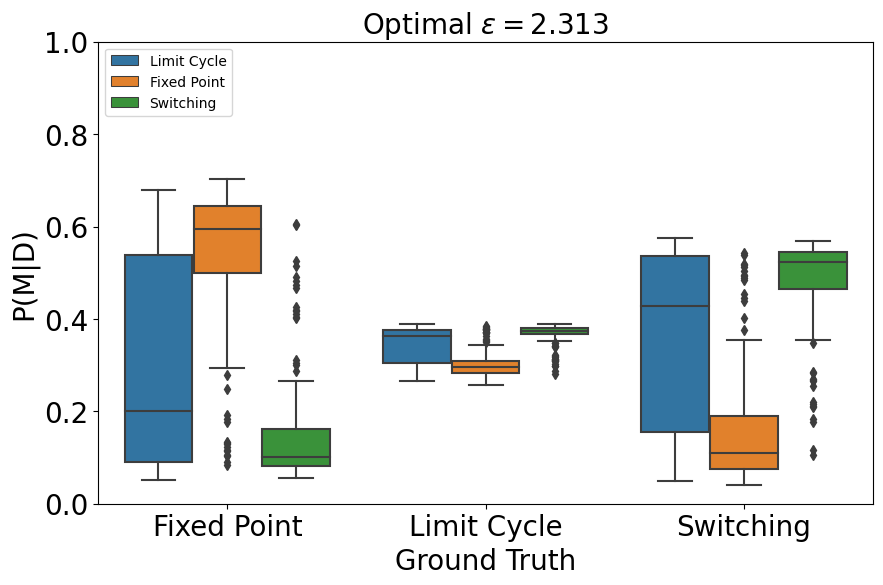

In [236]:
df_melted2 = df_post2.melt(id_vars='ground_truth', var_name='Model', value_name='Predicted probability')

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Predicted probability', hue='ground_truth', data=df_melted2)
plt.title('Optimal $\epsilon = {}$'.format(np.round(optimal_threshold2, 3)), fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Ground Truth', fontsize=20)
plt.ylabel('P(M|D)', fontsize=20)
plt.legend(loc='upper left')
plt.ylim(0, 1)
plt.savefig('highNoise_lowN.svg', transparent=True)
#plt.show()

Case 3

In [132]:
ts_lc_high_sig_high_N, df_lc_high_sig_high_N = gen_limitCycle(1000, N_fixed=2000, eta_fixed=1)
ts_fp_high_sig_high_N, df_fp_high_sig_high_N = gen_fixedpoint(1000, N_fixed=2000, eta_fixed=1)
ts_sw_high_sig_high_N, df_sw_high_sig_high_N = gen_switching(1000, N_fixed=2000, eta_fixed=1)

In [237]:
df_combined_regimes3 = pd.concat([df_lc_high_sig_high_N, df_fp_high_sig_high_N, df_sw_high_sig_high_N], ignore_index=True)
ts_combined_regimes3 = ts_lc_high_sig_high_N + ts_fp_high_sig_high_N + ts_sw_high_sig_high_N

In [238]:
rs3 = RobustScaler().fit(df_combined_regimes3.iloc[:,:22])
rs_fit3 = rs3.transform(df_combined_regimes3.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer3 = FunctionTransformer(sigmoid, kw_args={'theta': 3})
sigmoid_transformer3.fit(rs_fit3)
sigmoid_fit3 = sigmoid_transformer3.transform(rs_fit3)
mm3 = MinMaxScaler().fit(sigmoid_fit3)
mm_fit3 = mm.transform(sigmoid_fit3)
xhat3 = mm_fit3

In [239]:
pca_fit = PCA(n_components=2).fit(mm_fit3)
pca = pca_fit.transform(mm_fit3)

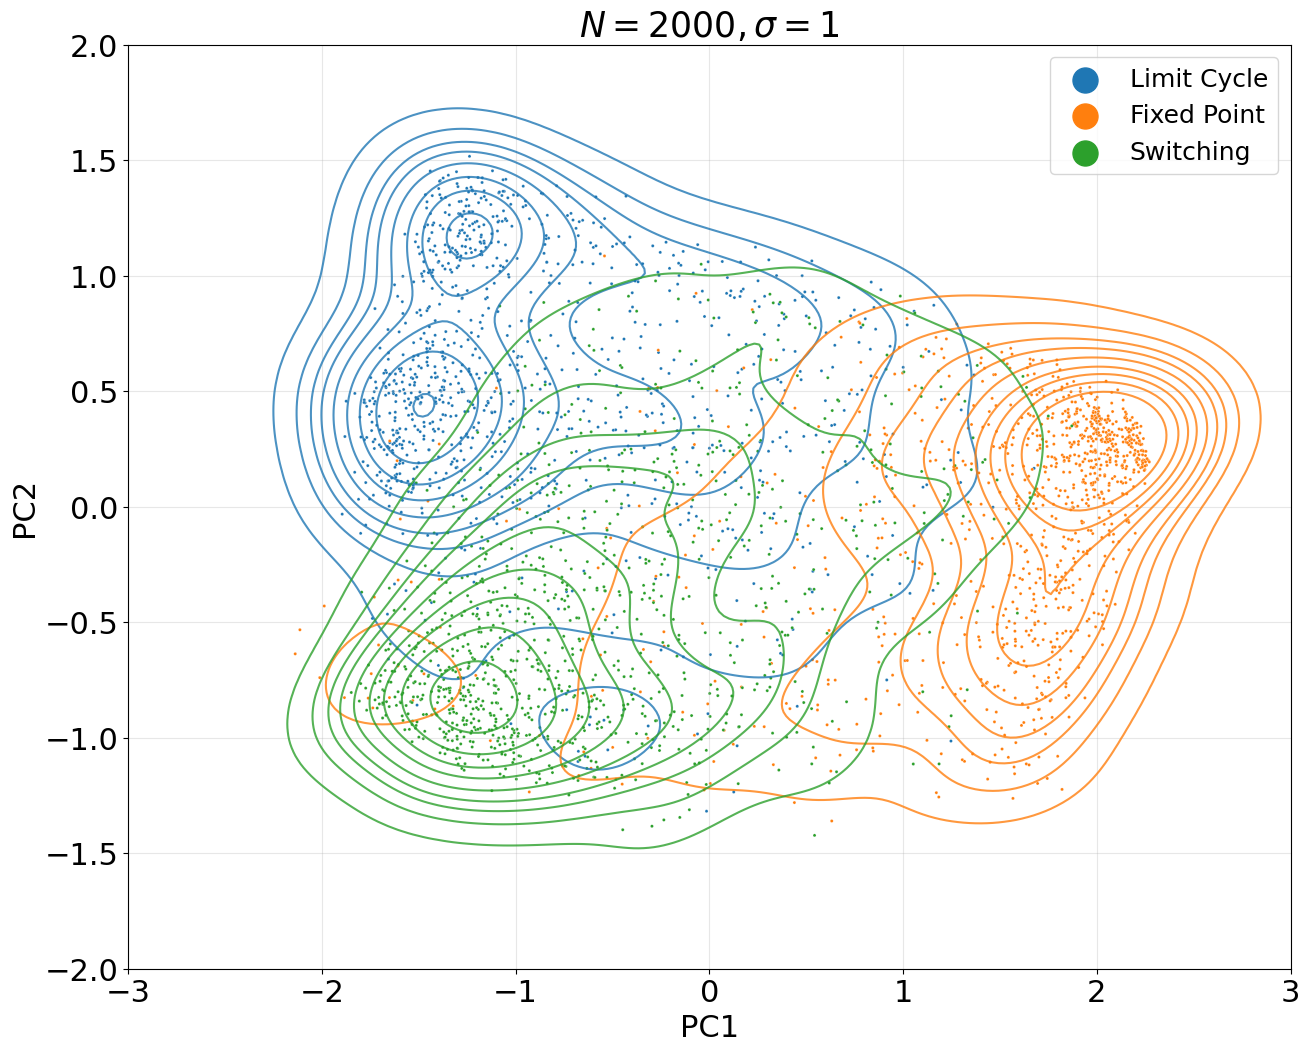

In [240]:
plt.figure(figsize=(15,12))
plt.grid(alpha=0.3)
sns.kdeplot(x=pca[:,0], y=pca[:,1], levels=10, hue=df_combined_regimes2['regime'], alpha=0.8)
sns.scatterplot(x=pca[:,0], y=pca[:,1], s=5, hue=df_combined_regimes2['regime'])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('PC1', fontsize=22)
plt.ylabel('PC2', fontsize=22)
plt.title('$N = 2000, \sigma = 1$', fontsize=25)
plt.xlim(-3, 3)
plt.ylim(-2, 2)
plt.legend(markerscale=3, fontsize=18)
plt.savefig('high_noise_high_N_alt_sampling.svg', dpi=420, transparent=True)

In [241]:
replace_values = {'Hookes Fixed Point' : 'Fixed Point', 
                  'Bistable Fixed Point' : 'Fixed Point',
                  'Hopf Fixed Point' : 'Fixed Point',
                  'Hopf Limit Cycle' : 'Limit Cycle',
                  'Bistable Switching' : 'Switching'}
df_combined_regimes3['behaviour'] = df_combined_regimes3['regime'].replace(replace_values)

In [242]:
df_normalised3 = pd.DataFrame(xhat3)
df_normalised3['regime'] = df_combined_regimes3['regime']
df_normalised3['behaviour'] = df_combined_regimes3['behaviour']
df_normalised3['N'] = df_combined_regimes3['N']
df_normalised3['mu'] = df_combined_regimes3['mu']
df_normalised3['eta'] = df_combined_regimes3['eta']

In [243]:
df_xhat_limit_cycle3 = df_normalised3[df_normalised3['behaviour'] == 'Limit Cycle'].drop(columns={'regime', 'behaviour', 'N', 'mu', 'eta'})
df_xhat_fixed_point3 = df_normalised3[df_normalised3['behaviour'] == 'Fixed Point'].drop(columns={'regime', 'behaviour', 'N', 'mu', 'eta'})
df_xhat_switching3 = df_normalised3[df_normalised3['behaviour'] == 'Switching'].drop(columns={'regime', 'behaviour', 'N', 'mu', 'eta'})

In [244]:
## within class distances
dist_within_limit_cycle3 = pairwise_distances(df_xhat_limit_cycle3, metric='euclidean')
dist_within_fixed_point3= pairwise_distances(df_xhat_fixed_point3, metric='euclidean')
dist_within_switching3 = pairwise_distances(df_xhat_switching3, metric='euclidean')

# remove double counting
dist_within_limit_cycle3 = dist_within_limit_cycle3[np.triu_indices(dist_within_limit_cycle3.shape[0], k=1)]
dist_within_fixed_point3 = dist_within_fixed_point3[np.triu_indices(dist_within_fixed_point3.shape[0], k=1)]
dist_within_switching3 = dist_within_switching3[np.triu_indices(dist_within_switching3.shape[0], k=1)]

## between class distances
limit_cycle_to_fixed_point3 = pairwise_distances(df_xhat_limit_cycle3, df_xhat_fixed_point3, metric='euclidean').flatten()
limit_cycle_to_switching3 = pairwise_distances(df_xhat_limit_cycle3, df_xhat_switching3, metric='euclidean').flatten()
fixed_point_to_switching3 = pairwise_distances(df_xhat_fixed_point3, df_xhat_switching3, metric='euclidean').flatten()

## Now combine within class (regime) and between class (regime) distances
within_class3 = np.concatenate([dist_within_limit_cycle3, dist_within_fixed_point3, dist_within_switching3])
between_class3 = np.concatenate([limit_cycle_to_fixed_point3, limit_cycle_to_switching3, fixed_point_to_switching3])

In [245]:
fpr3, tpr3, roc_auc3, optimal_threshold3 = select_epsilon(within_class3, between_class3)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

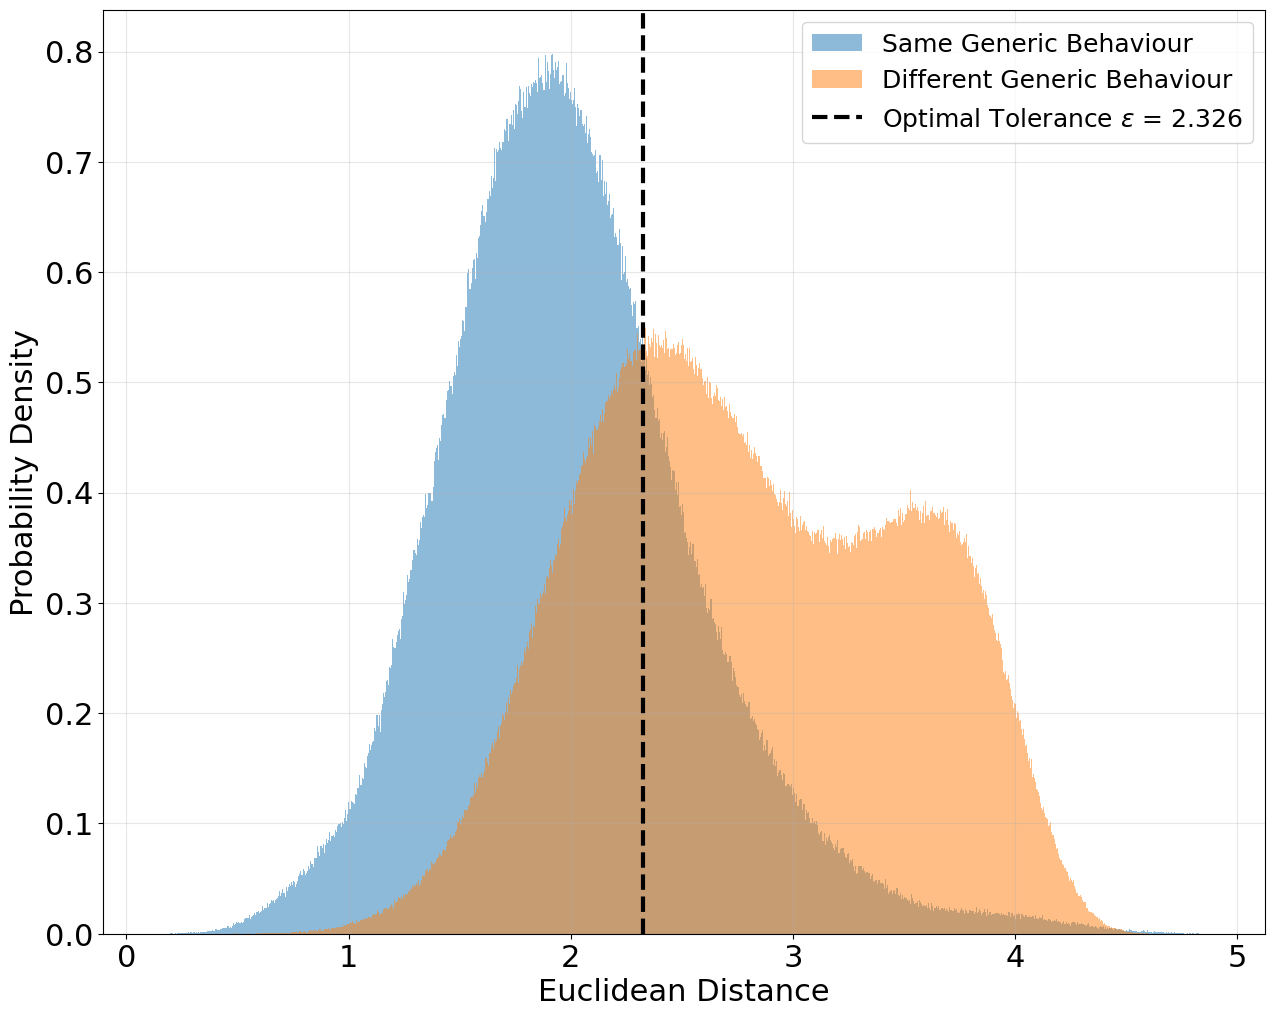

In [142]:
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)
plt.hist(within_class3, bins=1000, alpha=0.5, label='Same Generic Behaviour', density=True)
plt.hist(between_class3, bins=1000, alpha=0.5, label='Different Generic Behaviour', density=True)
plt.axvline(optimal_threshold3, color='k', linestyle='dashed', linewidth=3, label='Optimal Tolerance $\epsilon$ = {}'.format(np.round(optimal_threshold3, 3)))
plt.legend(fontsize=18)
plt.xlabel('Euclidean Distance', fontsize=22)
plt.ylabel('Probability Density', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

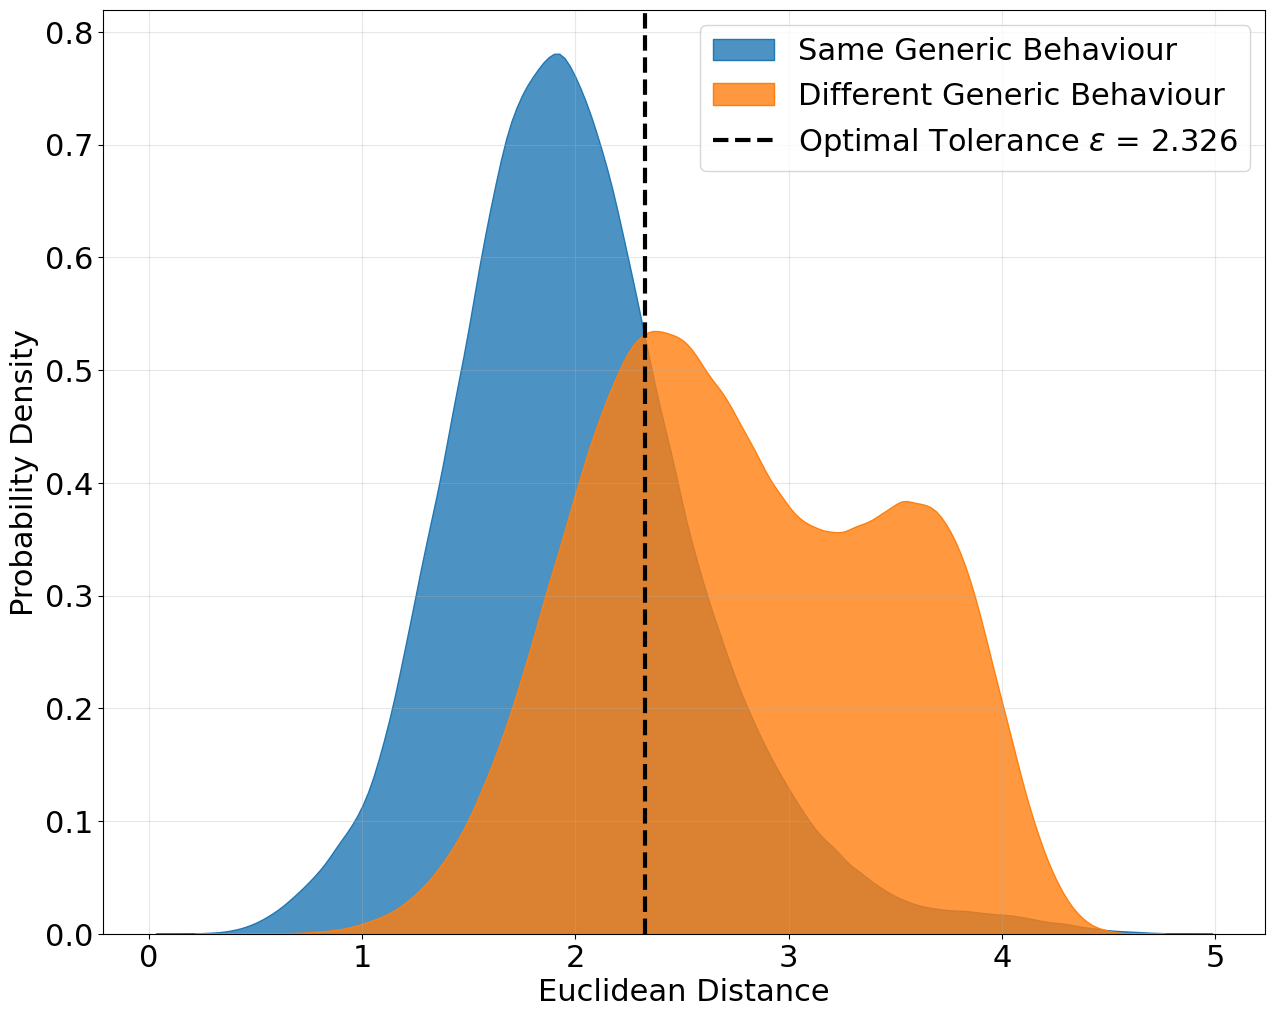

In [246]:
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)
sns.kdeplot(x=within_class3, label='Same Generic Behaviour', fill=True, alpha=0.8)
sns.kdeplot(x=between_class3, label='Different Generic Behaviour', fill=True, alpha=0.8)
plt.axvline(optimal_threshold3, color='k', linestyle='dashed', linewidth=3, label='Optimal Tolerance $\epsilon$ = {}'.format(np.round(optimal_threshold3, 3)))
plt.legend(fontsize=22)
plt.xlabel('Euclidean Distance', fontsize=22)
plt.ylabel('Probability Density', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.savefig('high_noise_high_N_alt_sampling_kde.png', dpi=420, transparent=True)


In [252]:
df_combined_regimes3[df_combined_regimes3['regime'] == 'Switching']

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,N,mu,eta,model,regime,behaviour
1999,-0.704331,-0.929193,77.248579,221.0,0.999834,-0.000059,0.737369,250.0,0.010204,356.0,...,0.673469,0.755102,0.012272,0.149843,2000,0.244090,1,Bistable,Switching,Switching
2000,-0.376309,-0.590380,133.040520,412.0,1.025285,-0.000083,0.718359,441.0,0.008230,608.0,...,0.877551,0.816327,0.006136,0.134116,2000,-0.376912,1,Bistable,Switching,Switching
2001,0.829049,0.615323,159.576438,367.0,0.992319,0.000086,0.708854,376.0,0.047619,624.0,...,0.142857,0.877551,0.006136,0.140055,2000,0.200320,1,Bistable,Switching,Switching
2002,-0.443176,-0.679713,73.511081,158.0,0.863358,0.000421,0.779390,288.0,0.032922,366.0,...,0.265306,0.734694,0.009204,0.188336,2000,-0.205670,1,Bistable,Switching,Switching
2003,0.727985,0.943772,98.580743,258.0,1.040003,-0.000023,0.747374,414.0,0.038567,378.0,...,0.755102,0.591837,0.006136,0.146406,2000,-0.166327,1,Bistable,Switching,Switching
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,-0.763449,-0.542284,144.041053,108.0,0.967378,0.000120,0.747374,425.0,0.125000,387.0,...,0.591837,0.510204,0.009204,0.153522,2000,0.235195,1,Bistable,Switching,Switching
2995,-0.537929,-0.329619,190.914881,504.0,1.037539,0.000004,0.725363,518.0,0.034014,167.0,...,0.469388,0.244898,0.006136,0.141822,2000,0.080482,1,Bistable,Switching,Switching
2996,-0.704934,-0.920734,183.801571,476.0,0.982493,0.000006,0.699350,563.0,0.027778,0.0,...,0.204082,0.877551,0.006136,0.132603,2000,-0.223169,1,Bistable,Switching,Switching
2997,0.702664,0.904807,400.897245,220.0,1.060665,0.000064,0.686843,510.0,0.074074,395.0,...,0.346939,0.877551,0.003068,0.128771,2000,0.054682,1,Bistable,Switching,Switching


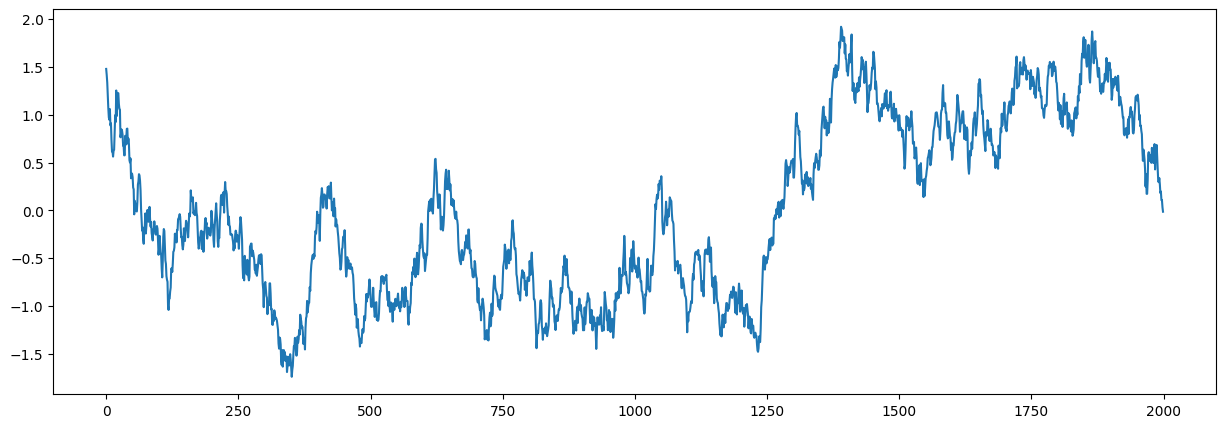

In [260]:
plt.figure(figsize=(15,5))
plt.plot(ts_combined_regimes3[2123])
plt.savefig('N2000SIG1_b_sw.svg', transparent=True)

In [261]:
abc3 = RadiusNeighborsClassifier(radius=optimal_threshold3, outlier_label='most_frequent')
abc3.fit(df_normalised3.iloc[:,:22], df_normalised3['regime'])


RadiusNeighborsClassifier(outlier_label='most_frequent',
                          radius=2.325914266079534)

In [263]:
ts_lc_test3, df_lc_test3 = gen_limitCycle(200, N_fixed=2000, eta_fixed=1)
ts_fp_test3, df_fp_test3 = gen_fixedpoint(200, N_fixed=2000, eta_fixed=1)
ts_sw_test3, df_sw_test3 = gen_switching(200, N_fixed=2000, eta_fixed=1)
df_test3 = pd.concat([df_lc_test3, df_fp_test3, df_sw_test3], ignore_index=True)
xhat_test3 = mm3.transform(sigmoid_transformer3.transform(rs3.transform(df_test3.iloc[:,:22])))
ts_test3 = ts_lc_test3 + ts_fp_test3 + ts_sw_test3

In [264]:
posterior3 = abc3.predict_proba(xhat_test3)

In [265]:
classes3 = abc3.classes_

In [266]:
df_post3 = pd.DataFrame(posterior3, columns=[classes3[0], classes3[1], classes3[2]])
df_post3['ground_truth'] = df_test3['regime']

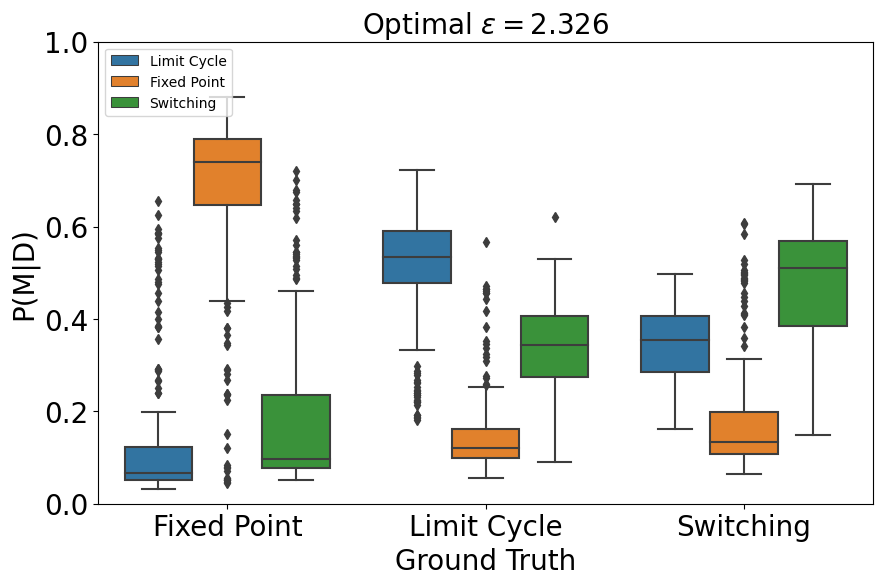

In [268]:
df_melted3 = df_post3.melt(id_vars='ground_truth', var_name='Model', value_name='Predicted probability')

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Predicted probability', hue='ground_truth', data=df_melted3)
plt.title('Optimal $\epsilon = {}$'.format(np.round(optimal_threshold3, 3)), fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Ground Truth', fontsize=20)
plt.ylabel('P(M|D)', fontsize=20)
plt.legend(loc='upper left')
plt.ylim(0, 1)
plt.savefig('highNoise_highN.svg', transparent=True)
plt.show()

## Epsilon Curves

In [ ]:
def gen_epsilon_curve(eta_fixed, N_fixed, n_trials=3):
    # generate data